In [322]:
import pandas as pd
import matplotlib.pyplot as plt

data_path = "./data_sets/"

df_patients= pd.read_csv(data_path + 'PATIENTS.csv.gz')        
df_admissions = pd.read_csv(data_path + 'ADMISSIONS.csv.gz')        
df_icustays = pd.read_csv(data_path + 'ICUSTAYS.csv.gz')     
df_diagnoses = pd.read_csv(data_path + 'DIAGNOSES_ICD.csv.gz', low_memory=False) 


In [323]:
# Filter for Pneumonia (ICD-9 = 48283)
df_target = df_diagnoses[df_diagnoses['ICD9_CODE'] == '48283'][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']]

print(df_target.shape)
df_target.head()

(264, 3)


,SUBJECT_ID,HADM_ID,ICD9_CODE
38,114,178393,48283
4202,339,112625,48283
5063,285,165312,48283
7541,605,115545,48283
8075,720,171046,48283


In [324]:
df_admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [325]:
# Merge with admissions to get LOS
df_merged = pd.merge(
    df_target,
    df_admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ETHNICITY']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)
print(df_merged.shape)
df_merged.head()

(264, 5)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,ETHNICITY
0,114,178393,48283,2146-08-29 01:18:00,UNKNOWN/NOT SPECIFIED
1,339,112625,48283,2187-04-20 23:10:00,BLACK/AFRICAN AMERICAN
2,285,165312,48283,2152-09-21 22:47:00,HISPANIC OR LATINO
3,605,115545,48283,2197-11-09 12:59:00,ASIAN
4,720,171046,48283,2160-02-15 21:44:00,WHITE


In [326]:
df_icustays.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [327]:
# Merge with ICU stays (if any)
df_merged = pd.merge(
    df_merged,
    df_icustays[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'INTIME', 'LOS']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'

)

df_merged.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,ETHNICITY,ICUSTAY_ID,INTIME,LOS
0,114,178393,48283,2146-08-29 01:18:00,UNKNOWN/NOT SPECIFIED,258626,2146-08-29 17:59:00,1.8132
1,339,112625,48283,2187-04-20 23:10:00,BLACK/AFRICAN AMERICAN,221278,2187-04-20 23:10:50,31.7018
2,285,165312,48283,2152-09-21 22:47:00,HISPANIC OR LATINO,238023,2152-09-21 22:48:50,28.6880
3,605,115545,48283,2197-11-09 12:59:00,ASIAN,248569,2197-11-09 13:00:45,16.8598
4,720,171046,48283,2160-02-15 21:44:00,WHITE,261862,2160-02-15 21:45:04,48.9253


In [328]:
df_patients.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [329]:
# Add patient demographics (optional)
df_merged = pd.merge(
    df_merged,
    df_patients[['SUBJECT_ID', 'GENDER', 'DOB']],
    on='SUBJECT_ID',
    how='left'
)

df_merged.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,ETHNICITY,ICUSTAY_ID,INTIME,LOS,GENDER,DOB
0,114,178393,48283,2146-08-29 01:18:00,UNKNOWN/NOT SPECIFIED,258626,2146-08-29 17:59:00,1.8132,M,2098-05-09 00:00:00
1,339,112625,48283,2187-04-20 23:10:00,BLACK/AFRICAN AMERICAN,221278,2187-04-20 23:10:50,31.7018,F,2120-07-17 00:00:00
2,285,165312,48283,2152-09-21 22:47:00,HISPANIC OR LATINO,238023,2152-09-21 22:48:50,28.6880,M,2107-05-16 00:00:00
3,605,115545,48283,2197-11-09 12:59:00,ASIAN,248569,2197-11-09 13:00:45,16.8598,F,1895-04-05 00:00:00
4,720,171046,48283,2160-02-15 21:44:00,WHITE,261862,2160-02-15 21:45:04,48.9253,F,2108-08-25 00:00:00


In [330]:
df_merged.isnull().sum()

SUBJECT_ID    0
HADM_ID       0
ICD9_CODE     0
ADMITTIME     0
ETHNICITY     0
ICUSTAY_ID    0
INTIME        0
LOS           0
GENDER        0
DOB           0
dtype: int64

In [331]:
df_merged['DOB'] = pd.to_datetime(df_merged['DOB'])
df_merged['INTIME'] = pd.to_datetime(df_merged['INTIME'])

df_merged['ADMITTIME'] = pd.to_datetime(df_merged['ADMITTIME'])

# Correctly subtract the years
df_merged['AGE'] = (
    (df_merged['INTIME'].dt.year - df_merged['DOB'].dt.year) + 
    (df_merged['INTIME'].dt.dayofyear - df_merged['DOB'].dt.dayofyear) / 365.25
)
# Time since admitted in the hospital
df_merged['ADMITIME'] = (
    (df_merged['INTIME'].dt.year - df_merged['ADMITTIME'].dt.year) + 
    (df_merged['INTIME'].dt.dayofyear - df_merged['ADMITTIME'].dt.dayofyear) / 365.25
)

# Can drop DOB, INTIME and ADMITE TIME
df_merged.drop(columns=['DOB', 'ADMITTIME'], inplace=True)

df_merged.loc[df_merged['AGE'] > 89, 'AGE'] = 91.4  # Handle MIMIC-III's >89 group

df_merged = df_merged[df_merged['LOS'] > 1]

df_merged = df_merged.nsmallest(len(df_merged), 'LOS')  # Remove 2 max LOS rows   

unique_ethnicities = df_merged['ETHNICITY'].unique()
print(unique_ethnicities)

ethnicity_counts = df_merged['ETHNICITY'].value_counts()
print(ethnicity_counts)

df_merged.head()

['WHITE' 'UNKNOWN/NOT SPECIFIED' 'BLACK/AFRICAN AMERICAN' 'OTHER'
 'HISPANIC/LATINO - PUERTO RICAN' 'UNABLE TO OBTAIN' 'ASIAN'
 'HISPANIC OR LATINO' 'WHITE - RUSSIAN' 'HISPANIC/LATINO - DOMINICAN'
 'ASIAN - CHINESE' 'PATIENT DECLINED TO ANSWER']
ETHNICITY
WHITE                             216
BLACK/AFRICAN AMERICAN             28
UNKNOWN/NOT SPECIFIED              22
HISPANIC OR LATINO                  7
OTHER                               6
ASIAN                               5
UNABLE TO OBTAIN                    4
PATIENT DECLINED TO ANSWER          3
HISPANIC/LATINO - PUERTO RICAN      2
WHITE - RUSSIAN                     2
HISPANIC/LATINO - DOMINICAN         1
ASIAN - CHINESE                     1
Name: count, dtype: int64


,SUBJECT_ID,HADM_ID,ICD9_CODE,ETHNICITY,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,ADMITIME
287,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.000000
291,94937,162005,48283,UNKNOWN/NOT SPECIFIED,280084,2107-01-18 11:11:21,1.1432,M,68.389459,0.066393
244,63941,126602,48283,UNKNOWN/NOT SPECIFIED,270748,2196-04-23 14:49:48,1.1496,F,74.917864,0.002738
14,3078,147024,48283,WHITE,272986,2175-12-09 15:03:51,1.1541,M,47.793977,0.021903
29,5062,123244,48283,WHITE,250261,2100-12-10 12:50:48,1.2110,M,71.835044,0.027379


In [332]:
# List rare ethnicities (adjust threshold as needed)
rare_ethnicities = ['HISPANIC/LATINO - PUERTO RICAN', 'WHITE - RUSSIAN', 
                    'HISPANIC/LATINO - DOMINICAN', 'ASIAN - CHINESE',
                    'UNABLE TO OBTAIN', 'PATIENT DECLINED TO ANSWER']

# Consolidate
df_merged['ETHNICITY'] = df_merged['ETHNICITY'].replace(rare_ethnicities, 'OTHER')
df_merged.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE,ETHNICITY,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,ADMITIME
287,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.000000
291,94937,162005,48283,UNKNOWN/NOT SPECIFIED,280084,2107-01-18 11:11:21,1.1432,M,68.389459,0.066393
244,63941,126602,48283,UNKNOWN/NOT SPECIFIED,270748,2196-04-23 14:49:48,1.1496,F,74.917864,0.002738
14,3078,147024,48283,WHITE,272986,2175-12-09 15:03:51,1.1541,M,47.793977,0.021903
29,5062,123244,48283,WHITE,250261,2100-12-10 12:50:48,1.2110,M,71.835044,0.027379


In [333]:
from sklearn.preprocessing import LabelEncoder


gender_encoder = LabelEncoder()

df_merged['GENDER'] = gender_encoder.fit_transform(df_merged['GENDER'])

print("Gender Classes:", gender_encoder.classes_)

df_merged = pd.get_dummies(
    df_merged, 
    columns=['ETHNICITY'], 
    prefix='ETH',
    drop_first=True
    )

print(df_merged.isnull().sum())

df_merged.head()

Gender Classes: ['F' 'M']
SUBJECT_ID                    0
HADM_ID                       0
ICD9_CODE                     0
ICUSTAY_ID                    0
INTIME                        0
LOS                           0
GENDER                        0
AGE                           0
ADMITIME                      0
ETH_BLACK/AFRICAN AMERICAN    0
ETH_HISPANIC OR LATINO        0
ETH_OTHER                     0
ETH_UNKNOWN/NOT SPECIFIED     0
ETH_WHITE                     0
dtype: int64


,SUBJECT_ID,HADM_ID,ICD9_CODE,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,ADMITIME,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE
287,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.000000,False,False,False,False,True
291,94937,162005,48283,280084,2107-01-18 11:11:21,1.1432,1,68.389459,0.066393,False,False,False,True,False
244,63941,126602,48283,270748,2196-04-23 14:49:48,1.1496,0,74.917864,0.002738,False,False,False,True,False
14,3078,147024,48283,272986,2175-12-09 15:03:51,1.1541,1,47.793977,0.021903,False,False,False,False,True
29,5062,123244,48283,250261,2100-12-10 12:50:48,1.2110,1,71.835044,0.027379,False,False,False,False,True


In [334]:
df_ascending = df_merged.sort_values('LOS', ascending=True)
print("Top 5 Shortest LOS:")
# print(df_ascending[['SUBJECT_ID', 'HADM_ID','ICUSTAY_ID', 'LOS', 'INTIME', 'OUTTIME', 'age']].head())
df_ascending

Top 5 Shortest LOS:


,SUBJECT_ID,HADM_ID,ICD9_CODE,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,ADMITIME,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE
287,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.000000,False,False,False,False,True
291,94937,162005,48283,280084,2107-01-18 11:11:21,1.1432,1,68.389459,0.066393,False,False,False,True,False
244,63941,126602,48283,270748,2196-04-23 14:49:48,1.1496,0,74.917864,0.002738,False,False,False,True,False
14,3078,147024,48283,272986,2175-12-09 15:03:51,1.1541,1,47.793977,0.021903,False,False,False,False,True
29,5062,123244,48283,250261,2100-12-10 12:50:48,1.2110,1,71.835044,0.027379,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,22818,188392,48283,241236,2111-12-02 22:51:37,55.6687,0,73.405202,0.000000,True,False,False,False,False
138,21312,150854,48283,213825,2181-12-07 22:32:52,55.6920,0,76.547570,0.000000,False,False,False,False,True
53,7085,106726,48283,283819,2111-05-30 03:02:26,60.7469,0,42.027379,0.000000,False,False,False,False,True
106,16025,155705,48283,285837,2149-05-02 21:47:26,75.7236,0,57.125941,0.054757,False,False,False,False,True


In [335]:
df_descending = df_merged.sort_values('LOS', ascending=False)
print("\nTop 5 Longest LOS:")
# print(df_descending[['SUBJECT_ID', 'HADM_ID','ICUSTAY_ID', 'LOS', 'age']].head())
df_descending


Top 5 Longest LOS:


,SUBJECT_ID,HADM_ID,ICD9_CODE,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,ADMITIME,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE
43,6702,157559,48283,220172,2129-06-09 16:18:26,84.0409,1,80.644079,0.142368,False,False,False,False,True
106,16025,155705,48283,285837,2149-05-02 21:47:26,75.7236,0,57.125941,0.054757,False,False,False,False,True
53,7085,106726,48283,283819,2111-05-30 03:02:26,60.7469,0,42.027379,0.000000,False,False,False,False,True
138,21312,150854,48283,213825,2181-12-07 22:32:52,55.6920,0,76.547570,0.000000,False,False,False,False,True
140,22818,188392,48283,241236,2111-12-02 22:51:37,55.6687,0,73.405202,0.000000,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,5062,123244,48283,250261,2100-12-10 12:50:48,1.2110,1,71.835044,0.027379,False,False,False,False,True
14,3078,147024,48283,272986,2175-12-09 15:03:51,1.1541,1,47.793977,0.021903,False,False,False,False,True
244,63941,126602,48283,270748,2196-04-23 14:49:48,1.1496,0,74.917864,0.002738,False,False,False,True,False
291,94937,162005,48283,280084,2107-01-18 11:11:21,1.1432,1,68.389459,0.066393,False,False,False,True,False


In [336]:
df_merged.shape

(297, 14)

In [337]:
df_merged.describe().T

,count,mean,min,25%,50%,75%,max,std
SUBJECT_ID,297.0,33261.646465,114.0,11235.0,25474.0,48885.0,99715.0,28691.288358
HADM_ID,297.0,150159.565657,100395.0,125313.0,152457.0,174041.0,199845.0,27653.607582
ICUSTAY_ID,297.0,252482.037037,200387.0,231111.0,253774.0,275954.0,299728.0,28313.81701
INTIME,297,2150-07-19 20:50:48.461279232,2100-12-10 12:50:48,2124-03-21 23:14:40.999999488,2150-04-21 13:05:23.000000512,2174-08-18 19:05:27.000000512,2207-12-13 20:57:20,NaN
LOS,297.0,15.918696,1.1159,5.1157,12.6697,21.8292,84.0409,13.684957
GENDER,297.0,0.643098,0.0,0.0,1.0,1.0,1.0,0.479894
AGE,297.0,65.326929,19.350445,57.378508,68.054757,76.865845,91.4,15.921112
ADMITIME,297.0,0.01297,0.0,0.0,0.0,0.005476,0.468172,0.042997


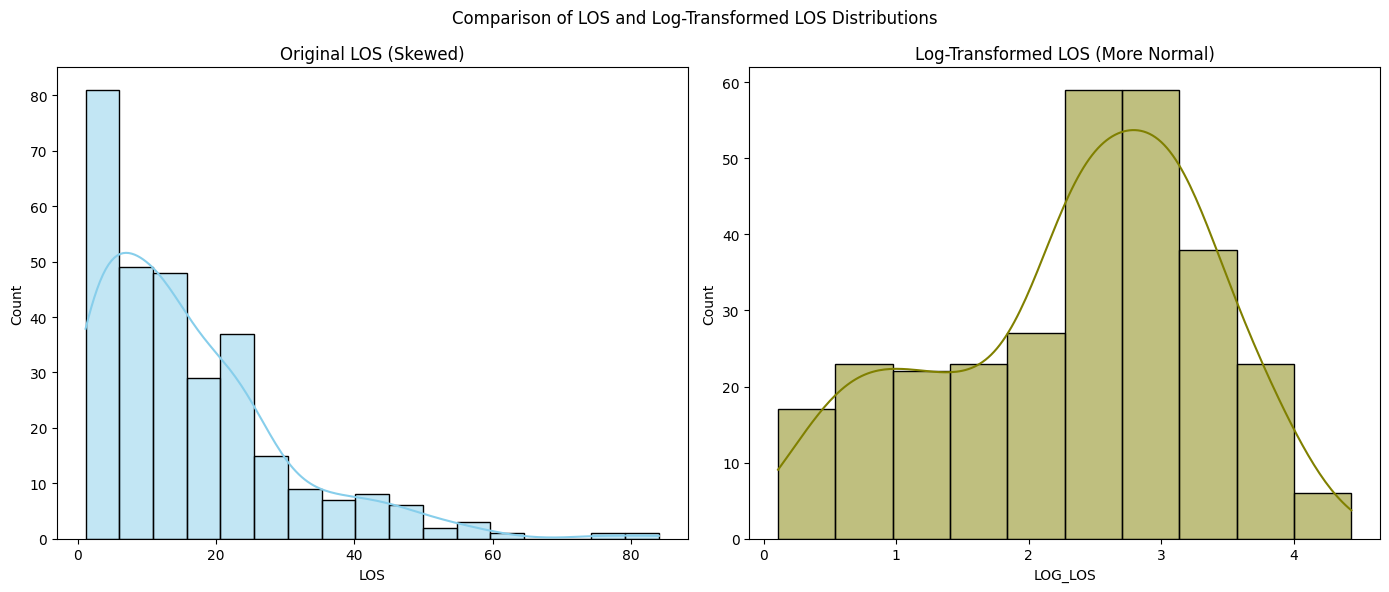

In [338]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_merged['LOG_LOS'] = np.log(df_merged['LOS'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Comparison of LOS and Log-Transformed LOS Distributions')

sns.histplot(df_merged['LOS'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Original LOS (Skewed)')

sns.histplot(df_merged['LOG_LOS'], kde=True, ax=axes[1], color='olive')
axes[1].set_title('Log-Transformed LOS (More Normal)')

plt.tight_layout()
plt.show()

In [339]:
# selected_small_id = 220271
# selected_mean_id =  284345
selected_big_id = 285837

icu_info = df_icustays[df_icustays['ICUSTAY_ID'] == selected_big_id]
icu_info


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
24829,20284,16025,155705,285837,carevue,TSICU,MICU,14,50,2149-05-02 21:47:26,2149-07-17 15:09:22,75.7236


In [340]:
starttime = pd.to_datetime(icu_info['INTIME'].iloc[0])
endtime = starttime + pd.Timedelta(hours=24)

starttime, endtime


(Timestamp('2149-05-02 21:47:26'), Timestamp('2149-05-03 21:47:26'))

In [341]:
print(df_merged.shape)
df_merged.head()

(297, 15)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,ADMITIME,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE,LOG_LOS
287,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.000000,False,False,False,False,True,0.109661
291,94937,162005,48283,280084,2107-01-18 11:11:21,1.1432,1,68.389459,0.066393,False,False,False,True,False,0.133831
244,63941,126602,48283,270748,2196-04-23 14:49:48,1.1496,0,74.917864,0.002738,False,False,False,True,False,0.139414
14,3078,147024,48283,272986,2175-12-09 15:03:51,1.1541,1,47.793977,0.021903,False,False,False,False,True,0.143321
29,5062,123244,48283,250261,2100-12-10 12:50:48,1.2110,1,71.835044,0.027379,False,False,False,False,True,0.191446


In [342]:
# df_chart_events =  pd.read_csv(data_path + 'chart_events_bronchitis.csv', low_memory=False)
df_chart_events =  pd.read_csv(data_path + 'd_pneumonia.csv', low_memory=False) 
 
print(df_chart_events.shape)      
df_chart_events.head()
# df_merged = pd.merge(df_merged, df_chart_events, how='inner')

# df_merged

(986962, 15)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,170754,1709,127294,207018,220052,2118-01-04 12:15:00,2118-01-04 14:22:00,19783.0,124.0,124.0,mmHg,0.0,0.0,NaN,NaN
1,170755,1709,127294,207018,220210,2118-01-04 12:15:00,2118-01-04 14:22:00,19783.0,30.0,30.0,insp/min,0.0,0.0,NaN,NaN
2,170756,1709,127294,207018,220277,2118-01-04 12:15:00,2118-01-04 14:22:00,19783.0,96.0,96.0,%,0.0,0.0,NaN,NaN
3,170757,1709,127294,207018,220179,2118-01-04 12:20:00,2118-01-04 14:22:00,19783.0,148.0,148.0,mmHg,0.0,0.0,NaN,NaN
4,170758,1709,127294,207018,220180,2118-01-04 12:20:00,2118-01-04 14:22:00,19783.0,69.0,69.0,mmHg,0.0,0.0,NaN,NaN


In [343]:
# 1. Merge df_merged with CHARTEVENTS (left join to preserve all ICU stays)
df_merged_with_chartevents = pd.merge(
    df_merged,  # Key columns
    df_chart_events[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'VALUENUM','CHARTTIME','VALUEUOM']].drop_duplicates(),
    on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'],
    how='left',
    indicator=True  # Adds a column '_merge' to show match status
)
# print(df_merged.columns)
# print(df_merged.shape)

# 2. Identify ICU stays with/without CHARTEVENTS
has_chartevents = df_merged_with_chartevents['_merge'] == 'both'
no_chartevents = df_merged_with_chartevents['_merge'] == 'left_only'

# 3. Get the lists of ICUSTAY_IDs
icu_with_data = df_merged_with_chartevents[has_chartevents]['ICUSTAY_ID'].unique()
icu_without_data = df_merged_with_chartevents[no_chartevents]['ICUSTAY_ID'].unique()

print(f"ICU stays WITH CHARTEVENTS data: {len(icu_with_data)}")
print(f"ICU stays WITHOUT CHARTEVENTS data: {len(icu_without_data)}")

df_merged_with_chartevents.head()

ICU stays WITH CHARTEVENTS data: 140
ICU stays WITHOUT CHARTEVENTS data: 157


,SUBJECT_ID,HADM_ID,ICD9_CODE,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,ADMITIME,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE,LOG_LOS,ITEMID,VALUENUM,CHARTTIME,VALUEUOM,_merge
0,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,False,False,False,False,True,0.109661,220277.0,94.0,2142-05-02 15:19:00,%,both
1,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,False,False,False,False,True,0.109661,223751.0,160.0,2142-05-02 15:19:00,mmHg,both
2,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,False,False,False,False,True,0.109661,223752.0,90.0,2142-05-02 15:19:00,mmHg,both
3,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,False,False,False,False,True,0.109661,223761.0,98.0,2142-05-02 15:19:00,?F,both
4,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,False,False,False,False,True,0.109661,223769.0,100.0,2142-05-02 15:19:00,%,both


<Axes: xlabel='NORMTIME', ylabel='Count'>

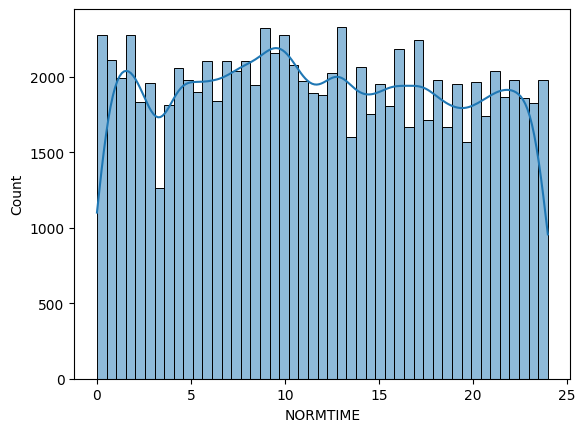

In [344]:
df_merged_with_chartevents['INTIME'] = pd.to_datetime(df_merged_with_chartevents['INTIME'])
df_merged_with_chartevents['CHARTTIME'] = pd.to_datetime(df_merged_with_chartevents['CHARTTIME'])

df_merged_with_chartevents.isnull().sum()

df_merged_with_chartevents['NORMTIME'] = (df_merged_with_chartevents['CHARTTIME'] - df_merged_with_chartevents['INTIME']).dt.total_seconds() / 3600
df_merged_with_chartevents = df_merged_with_chartevents[(df_merged_with_chartevents['NORMTIME'] < 24) &
                                                         (df_merged_with_chartevents['NORMTIME'] > 0)]
df_merged_with_chartevents.describe()
sns.histplot(df_merged_with_chartevents['NORMTIME'], kde=True)

<Axes: xlabel='NORMTIME', ylabel='Count'>

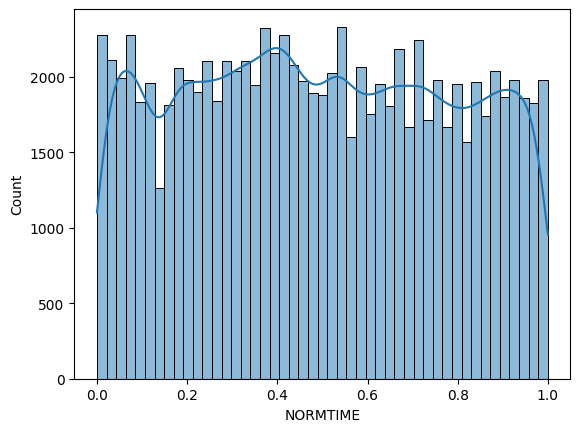

In [345]:
df_merged_with_chartevents['NORMTIME'] = df_merged_with_chartevents['NORMTIME'] / 24.0

sns.histplot(df_merged_with_chartevents['NORMTIME'], kde=True)

In [346]:
icu_with_data

array([243965, 280084, 270748, 210014, 200612, 285353, 284497, 201921,
       271827, 213653, 258626, 251009, 289137, 287844, 232180, 238731,
       274960, 265851, 202274, 275598, 251586, 203754, 248514, 239944,
       276330, 270331, 230391, 216379, 289186, 213339, 277618, 286609,
       295195, 241689, 275530, 234233, 223435, 232142, 202786, 231855,
       268113, 298668, 291479, 273636, 238708, 285599, 254293, 258212,
       216695, 278100, 210160, 296298, 240714, 291691, 254474, 254093,
       217440, 217726, 276468, 257533, 200387, 277323, 256557, 270380,
       270240, 247111, 277079, 214087, 299321, 200696, 264601, 241032,
       258054, 243197, 201667, 262172, 274718, 214175, 259979, 278016,
       293675, 231719, 231717, 269593, 254214, 280339, 249469, 215264,
       279995, 230131, 219048, 236989, 299407, 213159, 271393, 273705,
       226191, 248569, 282753, 293738, 243478, 241783, 244528, 292713,
       251832, 274326, 288087, 295935, 212945, 235268, 212116, 228565,
      

In [347]:
df_merged_with_chartevents.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE', 'ICUSTAY_ID', 'INTIME', 'LOS',
       'GENDER', 'AGE', 'ADMITIME', 'ETH_BLACK/AFRICAN AMERICAN',
       'ETH_HISPANIC OR LATINO', 'ETH_OTHER', 'ETH_UNKNOWN/NOT SPECIFIED',
       'ETH_WHITE', 'LOG_LOS', 'ITEMID', 'VALUENUM', 'CHARTTIME', 'VALUEUOM',
       '_merge', 'NORMTIME'],
      dtype='object')

<Axes: xlabel='AGE', ylabel='Count'>

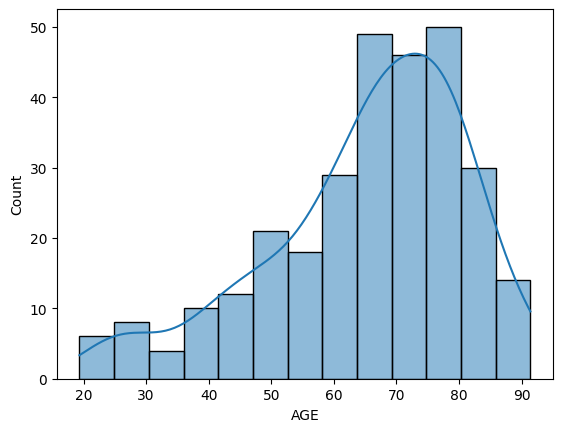

In [348]:
sns.histplot(df_merged['AGE'], kde=True)

In [349]:
df_merged.describe().T

,count,mean,min,25%,50%,75%,max,std
SUBJECT_ID,297.0,33261.646465,114.0,11235.0,25474.0,48885.0,99715.0,28691.288358
HADM_ID,297.0,150159.565657,100395.0,125313.0,152457.0,174041.0,199845.0,27653.607582
ICUSTAY_ID,297.0,252482.037037,200387.0,231111.0,253774.0,275954.0,299728.0,28313.81701
INTIME,297,2150-07-19 20:50:48.461279232,2100-12-10 12:50:48,2124-03-21 23:14:40.999999488,2150-04-21 13:05:23.000000512,2174-08-18 19:05:27.000000512,2207-12-13 20:57:20,NaN
LOS,297.0,15.918696,1.1159,5.1157,12.6697,21.8292,84.0409,13.684957
GENDER,297.0,0.643098,0.0,0.0,1.0,1.0,1.0,0.479894
AGE,297.0,65.326929,19.350445,57.378508,68.054757,76.865845,91.4,15.921112
ADMITIME,297.0,0.01297,0.0,0.0,0.0,0.005476,0.468172,0.042997
LOG_LOS,297.0,2.350774,0.109661,1.632314,2.539213,3.083249,4.431304,1.006111


In [351]:
print(df_merged_with_chartevents.shape)
df_merged_with_chartevents.drop(columns=['_merge','INTIME','CHARTTIME'],inplace=True)

df_merged_with_chartevents.head()

(92007, 21)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ICUSTAY_ID,LOS,GENDER,AGE,ADMITIME,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE,LOG_LOS,ITEMID,VALUENUM,VALUEUOM,NORMTIME
0,87980,110615,48283,243965,1.1159,1,65.748118,0.0,False,False,False,False,True,0.109661,220277.0,94.0,%,0.010903
1,87980,110615,48283,243965,1.1159,1,65.748118,0.0,False,False,False,False,True,0.109661,223751.0,160.0,mmHg,0.010903
2,87980,110615,48283,243965,1.1159,1,65.748118,0.0,False,False,False,False,True,0.109661,223752.0,90.0,mmHg,0.010903
3,87980,110615,48283,243965,1.1159,1,65.748118,0.0,False,False,False,False,True,0.109661,223761.0,98.0,?F,0.010903
4,87980,110615,48283,243965,1.1159,1,65.748118,0.0,False,False,False,False,True,0.109661,223769.0,100.0,%,0.010903


In [352]:
df_merged_with_chartevents.describe().T

,count,mean,std,min,25%,50%,75%,max
SUBJECT_ID,92007.0,70275.763475,27342.750886,114.000000,52901.000000,89223.000000,89223.000000,99715.000000
HADM_ID,92007.0,145898.831230,23387.607700,101117.000000,134966.000000,134966.000000,166373.000000,198412.000000
ICUSTAY_ID,92007.0,268558.793614,30362.824025,200387.000000,247111.000000,280339.000000,293675.000000,299407.000000
LOS,92007.0,13.419453,7.831780,1.115900,10.086900,13.137000,13.329100,48.925300
GENDER,92007.0,0.357864,0.479374,0.000000,0.000000,0.000000,1.000000,1.000000
AGE,92007.0,68.020550,12.555766,21.366872,64.744695,72.778234,72.778234,91.400000
ADMITIME,92007.0,0.004702,0.016746,0.000000,0.000000,0.000000,0.000000,0.158795
LOG_LOS,92007.0,2.406832,0.688070,0.109661,2.311238,2.575433,2.589950,3.890295
ITEMID,92007.0,218334.806308,31439.136106,39.000000,220181.000000,223834.000000,224695.000000,228444.000000
VALUENUM,91921.0,142.774545,8081.436175,-159.000000,9.000000,37.000000,90.000000,999999.000000


In [353]:
df_merged_with_chartevents.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE', 'ICUSTAY_ID', 'LOS', 'GENDER',
       'AGE', 'ADMITIME', 'ETH_BLACK/AFRICAN AMERICAN',
       'ETH_HISPANIC OR LATINO', 'ETH_OTHER', 'ETH_UNKNOWN/NOT SPECIFIED',
       'ETH_WHITE', 'LOG_LOS', 'ITEMID', 'VALUENUM', 'VALUEUOM', 'NORMTIME'],
      dtype='object')

In [364]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

features = ['GENDER',
       'AGE', 'ADMITIME', 'ETH_BLACK/AFRICAN AMERICAN',
       'ETH_HISPANIC OR LATINO', 'ETH_OTHER', 'ETH_UNKNOWN/NOT SPECIFIED',
       'ETH_WHITE', 'ITEMID', 'VALUENUM', 'NORMTIME']
df_merged_with_chartevents = df_merged_with_chartevents.dropna()

X = df_merged_with_chartevents[features]
# X = X.dropna()
y = df_merged_with_chartevents['LOG_LOS']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, # 20% for testing
    random_state=42 # for reproducible results
)

gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# 2. Train the model on the training data
gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [366]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Make predictions on the test data
y_pred = gbr.predict(X_test)

# If your target was LOG_LOS, you must convert predictions back to the original scale
y_pred_original_scale = np.expm1(y_pred)
y_test_original_scale = np.expm1(y_test)

# 2. Calculate metrics
mae = mean_absolute_error(y_test_original_scale, y_pred_original_scale)
mse = mean_squared_error(y_test_original_scale, y_pred_original_scale)
r2 = r2_score(y_test_original_scale, y_pred_original_scale)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2 Score): {r2:.2f}")

Mean Absolute Error (MAE): 2.45
Mean Squared Error (MSE): 23.21
R-squared (R2 Score): 0.61
